In [20]:
import sys
import json
import os
import pandas as pd
import seaborn as sns
from itertools import chain

from IPython.display import HTML, display

from datasets import load_dataset,load_from_disk
from transformers import (AutoTokenizer, 
                          AutoModelForTokenClassification, 
                          DataCollatorForTokenClassification, 
                          TrainingArguments, 
                          Trainer,
                          pipeline)
import evaluate
import torch
import numpy as np

# Import custom functions
from Functions.Spacy_Tokenizer import *
from Functions.Ner_Visualizer import *
from Functions.tfidf_wordclouds import *

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix


#cuda test
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

No GPU available, using the CPU instead.


In [ ]:
#models should be loaded as this and same for datasets
#model = AutoModelForTokenClassification.from_pretrained("wejendorp/ABA_NER")

#load the cased and uncased model and dataset containing predictions
model_folder = "trained_models/uncased/best_model"
model_uncased = AutoModelForTokenClassification.from_pretrained(model_folder)
uncased_test = load_from_disk("trained_models/uncased/predictions_eval_test_conc")

model_folder = "trained_models/cased/best_model"
model_cased = AutoModelForTokenClassification.from_pretrained(model_folder)
cased_test = load_from_disk("trained_models/cased/predictions_eval_test_conc")


In [ ]:
# we have the spacy index for each predictions and need to make a mapping
# Define a function to process each record in the dataset

def get_correct_predictions(example):
    # Create a dictionary to store the first predicted label for each index
    first_pred_labels = {}    
    # Get the predicted labels and their corresponding indices from the record
    pred_labels = example['predicted_labels']
    indices = example['pred_to_spacy_token_idx']
    #remove None pairs:
    zipper = [(label, index) for label, index in zip(pred_labels, indices) if index is not None]    
    # Iterate through the predictions and indices
    for label, index in zipper:        
        # If the index has not been seen before, add it to the dictionary
        if index not in first_pred_labels:
            first_pred_labels[index] = label    
    # Get the range of indices
    min_index = min([pair[1] for pair in zipper])
    max_index = max([pair[1] for pair in zipper])    
    # Initialize a list of labels with "O" for each index in the range
    labels = ['O'] * (max_index - min_index + 1)
    
    # Fill in the labels from the first_pred_labels dictionary
    for index, label in first_pred_labels.items():
        labels[index - min_index] = label    
    # Return the processed result    
    return {'aligned_predictions': labels}

# use labels_int column to make new column called true labels:
# it uses the model config
def map_int_to_label(example,model=None):
    true_labels = [model.config.id2label[label_int] for label_int in example["labels_int"]]
    true_labels_truncated = true_labels[:len(example["aligned_predictions"])]
    return {"true_labels": true_labels, "true_labels_truncated": true_labels_truncated}


In [12]:
# Apply the two functions above to the dataset
uncased_test=uncased_test.map(get_correct_predictions)
uncased_test=uncased_test.map(map_int_to_label,fn_kwargs={"model":model_uncased})

cased_test=cased_test.map(get_correct_predictions)
cased_test=cased_test.map(map_int_to_label,fn_kwargs={"model":model_cased})

Map: 100%|██████████| 3338/3338 [00:10<00:00, 326.49 examples/s]


In [13]:
# get a list of all the true labels, use the truncated version to match the length of the aligned predictions
uncased_true_labels = list(chain(*uncased_test['true_labels_truncated']))
uncased_pred_labels = list(chain(*uncased_test['aligned_predictions']))

cased_true_labels = list(chain(*cased_test['true_labels_truncated']))
cased_pred_labels = list(chain(*cased_test['aligned_predictions']))
# the length of uncased_true_labels_truncated and cased_true_labels_truncated differ due to the fact that tokenizer are different for the two models

In [14]:
#this should be the same as for the regex model
unique_labels=list(model_uncased.config.id2label.values())

In [ ]:
# Compute confusion matrices
cm1 = confusion_matrix(uncased_true_labels, uncased_pred_labels, labels=unique_labels)
cm2 = confusion_matrix(cased_true_labels, cased_pred_labels, labels=unique_labels)

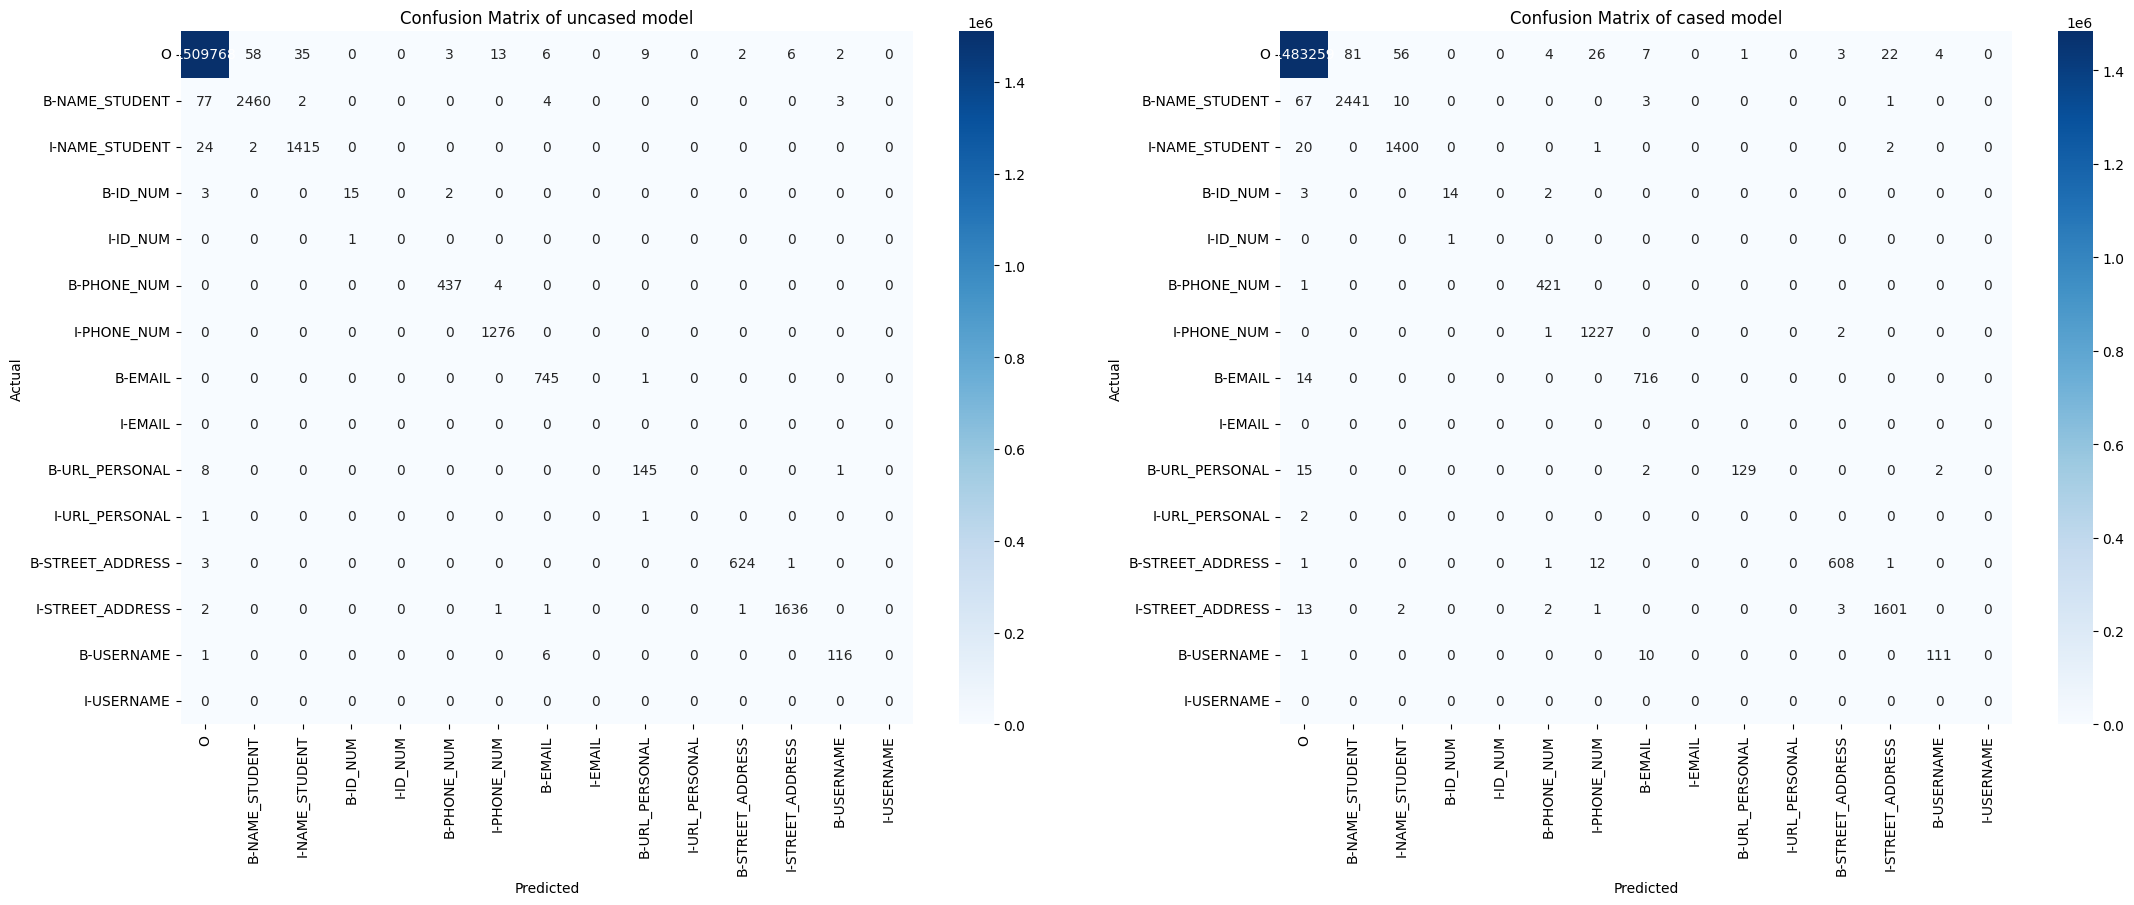

In [17]:
# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(26, 9))

# Plot the first confusion matrix on the first subplot
sns.heatmap(cm1, annot=True, fmt='d', xticklabels=unique_labels, yticklabels=unique_labels, cmap='Blues', cbar=True, ax=axes[0])
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')
axes[0].set_title('Confusion Matrix of uncased model')

# Plot the second confusion matrix on the second subplot
sns.heatmap(cm2, annot=True, fmt='d', xticklabels=unique_labels, yticklabels=unique_labels, cmap='Blues', cbar=True, ax=axes[1])
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')
axes[1].set_title('Confusion Matrix of cased model')
# Show the figure
plt.show()

In [36]:
# Function to calculate metrics for a model
def calculate_metrics(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')
    f1 = f1_score(true_labels, predicted_labels, average='micro')
    return [accuracy, precision, recall, f1]

def calculate_metrics_pr_label(true_labels, predicted_labels,unique_labels):
    #accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels,average=None,labels=unique_labels)
    recall = recall_score(true_labels, predicted_labels,average=None,labels=unique_labels)
    f1 = f1_score(true_labels, predicted_labels,average=None,labels=unique_labels)
    return [precision, recall, f1]


In [ ]:
# Calculate metrics for both models
metrics_uncased_model = calculate_metrics(uncased_true_labels, uncased_pred_labels)
metrics_cased_model = calculate_metrics(cased_true_labels, cased_pred_labels)

# Create a DataFrame with the metrics for each model
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision (Micro-average)", "Recall (Micro-average)", "F1 Score (Micro-average)"],
    "uncased model": metrics_uncased_model,
    "cased model": metrics_cased_model
})

# Display the DataFrame
print(metrics_df.to_string(index=False))

In [39]:
precision_uncased_model, recall_uncased_model, f1_uncased_model = calculate_metrics_pr_label(uncased_true_labels, uncased_pred_labels,unique_labels)
precision_cased_model, recall_cased_model, f1_cased_model = calculate_metrics_pr_label(cased_true_labels, cased_pred_labels,unique_labels)

/work3/s204090/PII-Detection-using-LLM/PII_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/work3/s204090/PII-Detection-using-LLM/PII_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/work3/s204090/PII-Detection-using-LLM/PII_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [42]:
def color_for_value(value):
    if value < 0.50:
        return "red"
    elif value < 0.70:
        return "yellow"
    else:
        return "green"

# Create an HTML table to display the metrics for both models
html = "<table style='width:100%; border: 1px solid black; border-collapse: collapse;'>"
html += "<tr>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>Model Type</th>"
html += "<th colspan='3' style='border: 1px solid black; padding: 8px; font-weight: bold; text-align: center;'>Uncased Model </th>"
html += "<th colspan='3' style='border: 1px solid black; padding: 8px; font-weight: bold; text-align: center;'>Cased Model</th>"
html += "</tr>"
html += "<tr>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>Metric</th>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>Precision</th>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>Recall</th>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>F1 Score</th>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>Precision</th>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>Recall</th>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>F1 Score</th>"
html += "</tr>"

# Add data rows for each class and each model
for label, p1, r1, f1, p2, r2, f2 in zip(unique_labels, precision_uncased_model, recall_uncased_model, f1_uncased_model, precision_cased_model, recall_cased_model, f1_cased_model):
    html += f"<tr>"
    html += f"<td style='border: 1px solid black; padding: 8px;'>{label}</td>"
    html += f"<td style='border: 1px solid black; padding: 8px; color: {color_for_value(p1)};'>{p1:.2f}</td>"
    html += f"<td style='border: 1px solid black; padding: 8px; color: {color_for_value(r1)};'>{r1:.2f}</td>"
    html += f"<td style='border: 1px solid black; padding: 8px; color: {color_for_value(f1)};'>{f1:.2f}</td>"
    html += f"<td style='border: 1px solid black; padding: 8px; color: {color_for_value(p2)};'>{p2:.2f}</td>"
    html += f"<td style='border: 1px solid black; padding: 8px; color: {color_for_value(r2)};'>{r2:.2f}</td>"
    html += f"<td style='border: 1px solid black; padding: 8px; color: {color_for_value(f2)};'>{f2:.2f}</td>"
    html += "</tr>"

# Close the HTML table
html += "</table>"

# Display the HTML table
display(HTML(html))

In [ ]:
zip(unique_labels, precision_uncased_model, recall_uncased_model, f1_uncased_model, precision_cased_model, recall_cased_model, f1_cased_model)